<a href="https://colab.research.google.com/github/aekanun2020/2023-Data-Science-for-Social-Commerce/blob/main/2023_Prediction_of_Customer_Behavior_with_DataViz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up Spark Environment

In [1]:
# Install necessary packages
!pip install pyspark==3.2.0

# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

# Create SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 MB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.8/198.8 kB 18.3 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805900 sha256=2bbf17cba841713f3f8f13dad84a0bdb57969fcae759d85cdad22a14fb12a964
  Stored in directory: /root/.cache/pip/wheels/32/97/d3/8b6d964c8700e4fbb561c71638a92ec55dac9be51eb5fea86d
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


## Libraries and Modules Installation

In [2]:
#Spark
from pyspark.sql import functions as sparkf
from pyspark.sql import Window as W
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

#Python
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from functools import reduce

## Data Collection

In [7]:
! wget https://storage.googleapis.com/22may2023/testfunnel.csv

--2023-05-18 14:35:49--  https://storage.googleapis.com/22may2023/testfunnel.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.63.128, 142.250.31.128, 142.251.111.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.63.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1501012 (1.4M) [text/csv]
Saving to: ‘testfunnel.csv’

testfunnel.csv      100%[===================>]   1.43M  --.-KB/s    in 0.04s   

2023-05-18 14:35:49 (33.0 MB/s) - ‘testfunnel.csv’ saved [1501012/1501012]



In [8]:
! head -3 testfunnel.csv

source,isTrueDirect,sourceKeyword,medium,isVideoAd,fullVisitorId,visitId,date,newVisits,hitReferer,hitType,hitAction_type,hitNumber,hitHour,hitMin,timeMicroSec,v2ProductName,productListName,isClick,isImpression,sessionQualityDim,timeOnScreen,timeOnSite,totalTransactionRevenue
google,true,(not provided),organic,,4988612949713423910,1489617360,20170315,,,PAGE,0,28,15,46,608771,Google Accent Insulated Stainless Steel Bottle,Category,,true,,,1897,
google,true,(not provided),organic,,4988612949713423910,1489617360,20170315,,,PAGE,0,27,15,46,605064,Google Pocket Bluetooth Speaker,Category,,true,,,1897,


In [9]:
! wc -l testfunnel.csv

10000 testfunnel.csv


In [10]:
raw_df = spark.read.option('header','true')\
.option("inferSchema" , "true")\
.format('csv').load('./testfunnel.csv')

# 1. Business Understanding

**ธุรกิจต้องการได้รับ Machine Learning Model ที่ทำให้ทราบล่วงหน้าว่า ลูกค้าที่กำลังเลือกดูสินค้าอยู่ จะซื้อหรือไม่ซื้อสินค้าหรือไม่ (Binary Classification)**

In [11]:
business_requiredCol_list = [x for x in raw_df.columns]

In [12]:
customerBehaviorCol_list = [x for x in raw_df.columns \
         if ((x != 'sourceKeyword')&(x != 'fullVisitorId')&(x != 'isVideoAd')&(x != 'date')\
             &(x != 'isTrueDirect')&(x != 'hitHour')&(x != 'hitMin')&(x != 'isClick')\
             &(x != 'productListName')&(x != 'isImpression')&(x != 'sessionQualityDim')&(x != 'timeOnScreen')\
             &(x != 'hitReferer')&(x != 'medium')&(x != 'hitType'))]

# 2. Data Understanding

### Previewing Data

In [13]:
raw_df.count()

9999

In [14]:
len(raw_df.columns)

24

In [15]:
raw_df.sample(0.001).toPandas().transpose()

,0,1,2,3,4,5,6,7
source,google,(direct),google,(direct),(direct),(direct),(direct),google
isTrueDirect,None,None,None,None,True,True,True,None
sourceKeyword,(not provided),None,(not provided),None,None,None,None,(not provided)
medium,organic,(none),organic,(none),(none),(none),(none),organic
isVideoAd,None,None,None,None,None,None,None,None
fullVisitorId,4989796484973187255,4993450863033496114,4993692613545178117,4993852637585406336,4993852637585406336,4993888514053304960,4995899860057743088,4995903322841177843
visitId,1473919452,1485313789,1489528333,1489938502,1489949902,1492820576,1474047117,1493223582
date,20160914,20170124,20170314,20170319,20170319,20170421,20160916,20170426
newVisits,1.0,1.0,1.0,1.0,NaN,1.0,NaN,1.0
hitReferer,None,None,None,None,None,None,None,None


In [16]:
raw_df.printSchema()

root
 |-- source: string (nullable = true)
 |-- isTrueDirect: boolean (nullable = true)
 |-- sourceKeyword: string (nullable = true)
 |-- medium: string (nullable = true)
 |-- isVideoAd: boolean (nullable = true)
 |-- fullVisitorId: long (nullable = true)
 |-- visitId: integer (nullable = true)
 |-- date: integer (nullable = true)
 |-- newVisits: integer (nullable = true)
 |-- hitReferer: string (nullable = true)
 |-- hitType: string (nullable = true)
 |-- hitAction_type: integer (nullable = true)
 |-- hitNumber: integer (nullable = true)
 |-- hitHour: integer (nullable = true)
 |-- hitMin: integer (nullable = true)
 |-- timeMicroSec: integer (nullable = true)
 |-- v2ProductName: string (nullable = true)
 |-- productListName: string (nullable = true)
 |-- isClick: boolean (nullable = true)
 |-- isImpression: boolean (nullable = true)
 |-- sessionQualityDim: integer (nullable = true)
 |-- timeOnScreen: string (nullable = true)
 |-- timeOnSite: integer (nullable = true)
 |-- totalTransac

### Exploratory Data Analysis - Univariate Analysis



In [17]:
raw_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
source,9999,None,None,(direct),youtube.com
sourceKeyword,4042,None,None,(not provided),youtube merch
medium,9999,None,None,(none),referral
fullVisitorId,9999,4.5067648825526333E18,1.39995873491150899E18,49898505875812980,4995924842281653133
visitId,9999,1.4850613864552455E9,9020666.664979974,1470106850,1501649190
date,9999,2.016601000310031E7,4694.944823979139,20160801,20170801
newVisits,7269,1.0,0.0,1,1
hitReferer,1333,None,None,http://images.google.co.in/imgres?imgurl=https...,https://www.youtube.com/yt/about/press/
hitType,9999,None,None,EVENT,PAGE


In [18]:
for a in business_requiredCol_list:
  raw_df.groupBy(a).count().orderBy('count',ascending = False).show()

+--------------------+-----+
|              source|count|
+--------------------+-----+
|            (direct)| 4972|
|              google| 4104|
|         youtube.com|  346|
|                 dfa|  185|
|            Partners|   84|
|       images.google|   75|
|          reddit.com|   58|
|analytics.google.com|   45|
|          google.com|   43|
|     blog.golang.org|   39|
|      m.facebook.com|   19|
|           quora.com|   12|
| images.google.co.in|   12|
|        facebook.com|    2|
|                t.co|    2|
|   groups.google.com|    1|
+--------------------+-----+

+------------+-----+
|isTrueDirect|count|
+------------+-----+
|        null| 6648|
|        true| 3351|
+------------+-----+

+--------------------+-----+
|       sourceKeyword|count|
+--------------------+-----+
|                null| 5957|
|      (not provided)| 3940|
|    6qEhsCssdK0z36ri|   65|
|google merchandis...|   13|
| okay google youtube|   12|
|       youtube merch|   12|
+--------------------+-----+

+

In [19]:
raw_df.groupBy('hitAction_type').count().orderBy('hitAction_type').show()

+--------------+-----+
|hitAction_type|count|
+--------------+-----+
|             0| 9437|
|             1|  210|
|             2|  163|
|             3|   59|
|             4|   20|
|             5|   70|
|             6|   40|
+--------------+-----+



In [20]:
raw_df.groupBy('isTrueDirect').count().show()

+------------+-----+
|isTrueDirect|count|
+------------+-----+
|        true| 3351|
|        null| 6648|
+------------+-----+



In [21]:
raw_df.groupBy('medium').count().show()

+---------+-----+
|   medium|count|
+---------+-----+
|   (none)| 4972|
|      cpc|   90|
| referral|  579|
|  organic| 3977|
|affiliate|   84|
|      cpm|  297|
+---------+-----+



In [22]:
#bins, counts = raw_df.select('hitNumber').rdd.flatMap(lambda x: x).histogram(10)
#plt.hist(bins[:-1], bins=bins, weights=counts)

In [23]:
#bins, counts = raw_df.select('hitNumber') \
#.filter(raw_df.hitAction_type != 6).rdd.flatMap(lambda x: x).histogram(10)
#plt.hist(bins[:-1], bins=bins, weights=counts)

In [24]:
#bins, counts = raw_df.select('hitNumber') \
#.filter(raw_df.hitAction_type == 6).rdd.flatMap(lambda x: x).histogram(10)
#plt.hist(bins[:-1], bins=bins, weights=counts)

In [25]:
#bins, counts = raw_df.select('hitHour').rdd.flatMap(lambda x: x).histogram(24)
#plt.hist(bins[:-1], bins=bins, weights=counts)

In [26]:
#bins, counts = raw_df.select('hitHour') \
#.filter(raw_df.hitAction_type != 6).rdd.flatMap(lambda x: x).histogram(24)
#plt.hist(bins[:-1], bins=bins, weights=counts)

In [27]:
df = raw_df.select(['hitAction_type','hitHour','hitMin','productListName']).toPandas()

ValueError: ignored

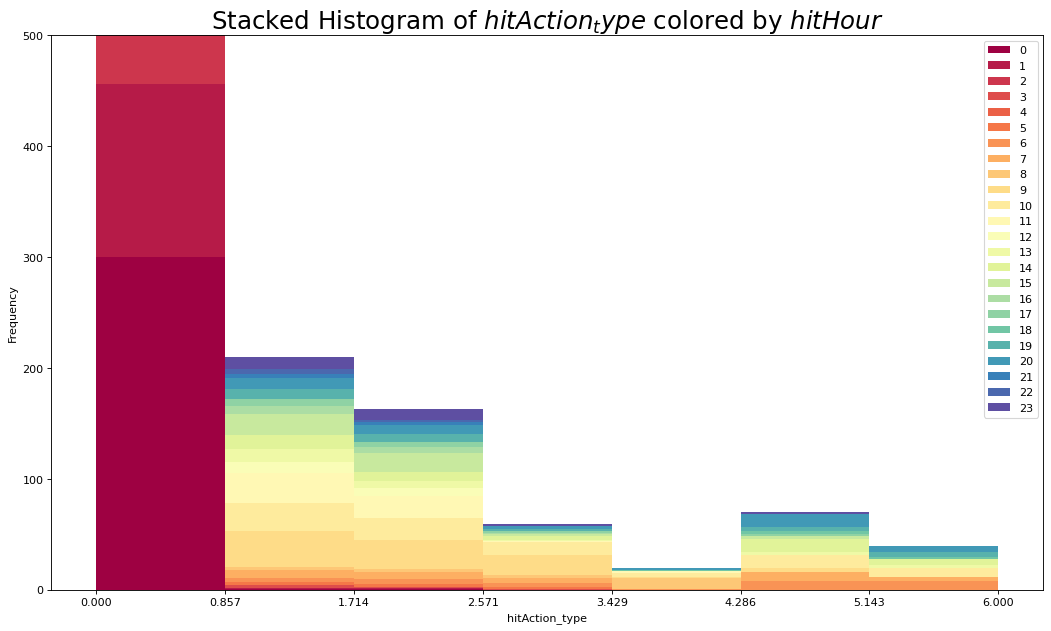

In [29]:
# Prepare data
x_var = 'hitAction_type'
groupby_var = 'hitHour'
df_agg = df.loc[:, [x_var, groupby_var]].groupby(groupby_var)
vals = [df[x_var].values.tolist() for i, df in df_agg]

# Draw
plt.figure(figsize=(16,9), dpi= 80)
colors = [plt.cm.Spectral(i/float(len(vals)-1)) for i in range(len(vals))]
n, bins, patches = plt.hist(vals, df[x_var].unique().__len__(), stacked=True, density=False, color=colors[:len(vals)])

# Decoration
plt.legend({group:col for group, col in zip(np.unique(df[groupby_var]).tolist(), colors[:len(vals)])})
plt.title(f"Stacked Histogram of ${x_var}$ colored by ${groupby_var}$", fontsize=22)
plt.xlabel(x_var)
plt.ylabel("Frequency")
plt.ylim(0, 500)
plt.xticks(ticks=bins, labels=np.unique(df[x_var]).tolist(), rotation=90, horizontalalignment='left')
plt.show()

In [30]:

raw_df.select(['hitAction_type','hitHour'])\
.filter((sparkf.col('hitAction_type') == 6) | (sparkf.col('hitAction_type') == 0))\
.groupBy('hitAction_type','hitHour').count()\
.orderBy(sparkf.col('hitAction_type').asc(),sparkf.col('hitHour').asc()).show(100)

+--------------+-------+-----+
|hitAction_type|hitHour|count|
+--------------+-------+-----+
|             0|      0|  300|
|             0|      1|  156|
|             0|      2|   96|
|             0|      3|  108|
|             0|      4|  202|
|             0|      5|  312|
|             0|      6|  239|
|             0|      7|  401|
|             0|      8|  668|
|             0|      9|  861|
|             0|     10|  768|
|             0|     11|  881|
|             0|     12|  559|
|             0|     13|  205|
|             0|     14|  449|
|             0|     15|  656|
|             0|     16|  302|
|             0|     17|  343|
|             0|     18|  182|
|             0|     19|  182|
|             0|     20|  355|
|             0|     21|  362|
|             0|     22|  256|
|             0|     23|  594|
|             6|      6|    8|
|             6|      7|    4|
|             6|     10|    8|
|             6|     13|    2|
|             6|     14|    6|
|       

(array([8., 4., 0., 0., 0., 0., 8., 0., 0., 0., 0., 0., 2., 6., 0., 0., 0.,
        0., 0., 0., 2., 0., 4., 6.]),
 array([ 6.        ,  6.58333333,  7.16666667,  7.75      ,  8.33333333,
         8.91666667,  9.5       , 10.08333333, 10.66666667, 11.25      ,
        11.83333333, 12.41666667, 13.        , 13.58333333, 14.16666667,
        14.75      , 15.33333333, 15.91666667, 16.5       , 17.08333333,
        17.66666667, 18.25      , 18.83333333, 19.41666667, 20.        ]),
 <BarContainer object of 24 artists>)

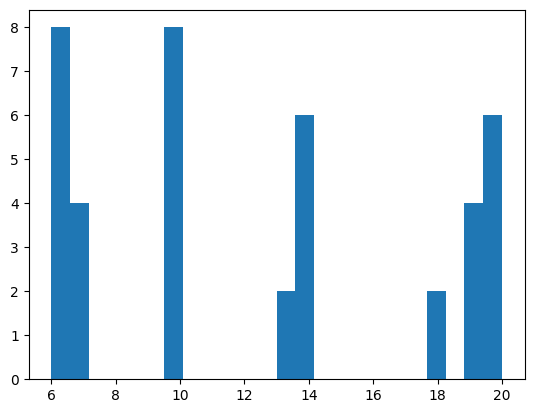

In [31]:
bins, counts = raw_df.select('hitHour') \
.filter(raw_df.hitAction_type == 6).rdd.flatMap(lambda x: x).histogram(24)
plt.hist(bins[:-1], bins=bins, weights=counts)

In [32]:
#bins, counts = raw_df.select('hitMin') \
#.rdd.flatMap(lambda x: x).histogram(4)
#plt.hist(bins[:-1], bins=bins, weights=counts)

In [33]:
#bins, counts = raw_df.select('hitMin') \
#.filter(raw_df.hitAction_type != 6).rdd.flatMap(lambda x: x).histogram(4)
#plt.hist(bins[:-1], bins=bins, weights=counts)

In [34]:
#bins, counts = raw_df.select('hitMin') \
#.filter(raw_df.hitAction_type == 6).rdd.flatMap(lambda x: x).histogram(4)
#plt.hist(bins[:-1], bins=bins, weights=counts)

ValueError: ignored

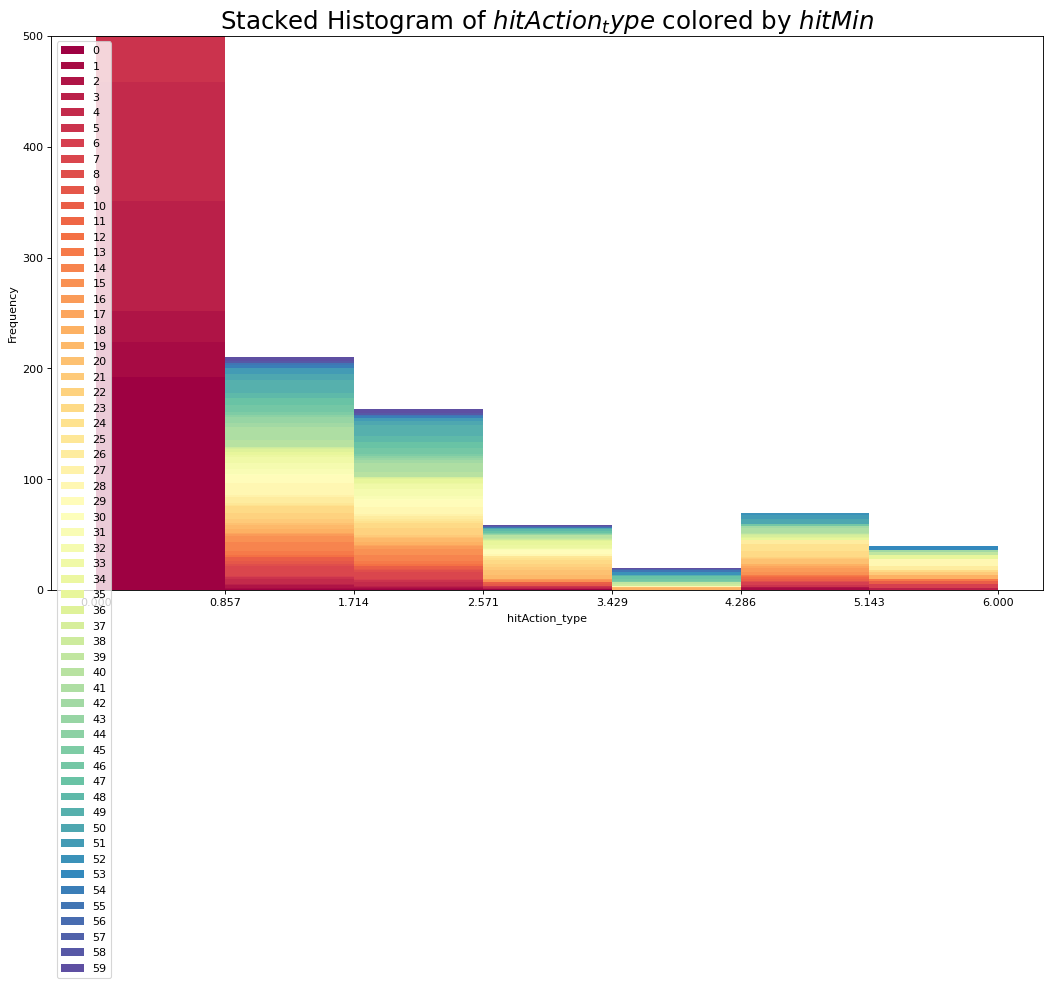

In [35]:
### hitMin

# Prepare data
x_var = 'hitAction_type'
groupby_var = 'hitMin'
df_agg = df.loc[:, [x_var, groupby_var]].groupby(groupby_var)
vals = [df[x_var].values.tolist() for i, df in df_agg]

# Draw
plt.figure(figsize=(16,9), dpi= 80)
colors = [plt.cm.Spectral(i/float(len(vals)-1)) for i in range(len(vals))]
n, bins, patches = plt.hist(vals, df[x_var].unique().__len__(), stacked=True, density=False, color=colors[:len(vals)])

# Decoration
plt.legend({group:col for group, col in zip(np.unique(df[groupby_var]).tolist(), colors[:len(vals)])})
plt.title(f"Stacked Histogram of ${x_var}$ colored by ${groupby_var}$", fontsize=22)
plt.xlabel(x_var)
plt.ylabel("Frequency")
plt.ylim(0, 500)
plt.xticks(ticks=bins, labels=np.unique(df[x_var]).tolist(), rotation=90, horizontalalignment='left')
plt.show()

ValueError: ignored

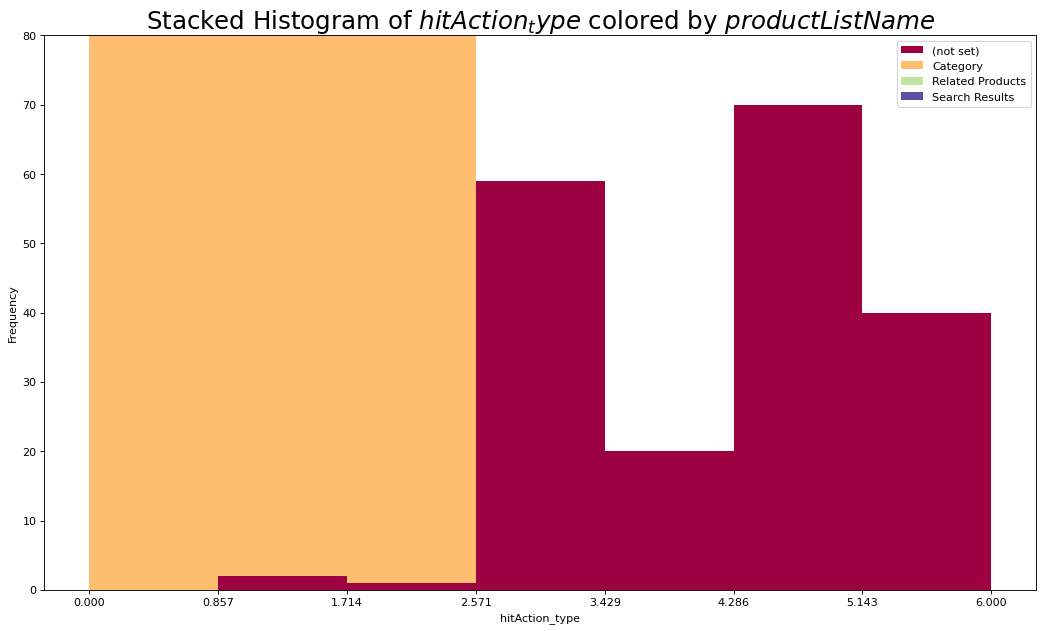

In [36]:
### productListName

# Prepare data
x_var = 'hitAction_type'
groupby_var = 'productListName'
df_agg = df.loc[:, [x_var, groupby_var]].groupby(groupby_var)
vals = [df[x_var].values.tolist() for i, df in df_agg]

# Draw
plt.figure(figsize=(16,9), dpi= 80)
colors = [plt.cm.Spectral(i/float(len(vals)-1)) for i in range(len(vals))]
n, bins, patches = plt.hist(vals, df[x_var].unique().__len__(), stacked=True, density=False, color=colors[:len(vals)])

# Decoration
plt.legend({group:col for group, col in zip(np.unique(df[groupby_var]).tolist(), colors[:len(vals)])})
plt.title(f"Stacked Histogram of ${x_var}$ colored by ${groupby_var}$", fontsize=22)
plt.xlabel(x_var)
plt.ylabel("Frequency")
plt.ylim(0, 80)
plt.xticks(ticks=bins, labels=np.unique(df[x_var]).tolist(), rotation=90, horizontalalignment='left')
plt.show()


### Finding out partial duplicated records - Spurious Patterns

*โค้ดด้านล่างแสดงให้เห็นว่า มีลูกค้ากี่ราย*

In [37]:
raw_df.select(sparkf.countDistinct('fullVisitorId').alias('num_unique_user')).show()

+---------------+
|num_unique_user|
+---------------+
|            242|
+---------------+



*โค้ดด้านล่างแสดงให้เห็นว่า ลูกค้าแต่ละราย (fullVisitorId) ที่เข้ามาได้หลายครั้ง (visitId) นั้นเกิด Hit ได้ตั้งแต่ 1 ครั้งขึ้นไป*

In [38]:
sessionWindow = W.partitionBy('fullVisitorId','visitId').orderBy(sparkf.col("hitNumber").cast("long"))\
                 .rangeBetween(-sys.maxsize, sys.maxsize)

In [39]:
allHit = sparkf.expr("count('hitNumber')")

In [40]:
raw_df.withColumn('numHit',allHit.over(sessionWindow))\
.select('fullVisitorId','visitId','numHit')\
.distinct().orderBy('fullVisitorId','visitId').show(7)

+------------------+----------+------+
|     fullVisitorId|   visitId|numHit|
+------------------+----------+------+
| 49898505875812980|1491367151|     2|
| 49898679051871719|1494605584|    14|
| 49898679051871719|1494616733|    18|
| 49898679051871719|1494874385|     1|
| 49898679051871719|1496681648|    12|
| 49898679051871719|1496681649|    12|
|498878131324403508|1483764178|    12|
+------------------+----------+------+
only showing top 7 rows



*โค้ดด้านล่าง เป็นการ cross-check ว่าการคำนวนข้างบนนั้นถูกต้องแล้ว*

In [41]:
raw_df.filter((sparkf.col('fullVisitorId') == '4991536060599177108')&(sparkf.col('VisitId') == '1495501367'))\
.count()

12

*โค้ดด้านล่างแสดงให้เห็นว่า บาง visitId เท่านั้นนั้นที่มี hitAction_type เป็นเลข 6*

In [42]:
raw_df\
      .withColumn('numHit',allHit.over(sessionWindow))\
      .withColumn('hitAction_type_6',sparkf.when(sparkf.col('hitAction_type')==6,1).otherwise(0))\
      .withColumn('sum_hitAction_type_6',sparkf.sum(sparkf.col('hitAction_type_6')).over(sessionWindow))\
      .filter(sparkf.col('sum_hitAction_type_6')>=1)\
      .select(['fullVisitorId','visitId','sum_hitAction_type_6'])\
      .distinct().orderBy('fullVisitorId','visitId').show()

+-------------------+----------+--------------------+
|      fullVisitorId|   visitId|sum_hitAction_type_6|
+-------------------+----------+--------------------+
|4988612949713423910|1490043910|                   4|
|4988683855814257726|1492045051|                   2|
|4989274933392395231|1487773059|                   6|
|4990198874063509353|1477021389|                   4|
|4993450863033496114|1485313789|                   4|
|4993485206334150199|1470106850|                   2|
|4993519711854402788|1487369367|                   2|
|4993852637585406336|1494000490|                   4|
|4995584940873803432|1497289186|                   2|
|4995584940873803432|1498486477|                   4|
|4995606827430436569|1488143869|                   2|
|4995899860057743088|1474047117|                   2|
|4995924842281653133|1486131356|                   2|
+-------------------+----------+--------------------+



*โค้ดด้านล่าง เป็นการ cross-check ว่าการคำนวนข้างบนนั้นถูกต้องแล้ว*

In [43]:
raw_df.filter(sparkf.col('totalTransactionRevenue') >=0)\
.groupBy('fullVisitorId','visitId').count().alias('numHit').orderBy('fullVisitorId','visitId').show()

+-------------------+----------+-----+
|      fullVisitorId|   visitId|count|
+-------------------+----------+-----+
|4988612949713423910|1490043910|   25|
|4988683855814257726|1492045051|   55|
|4989274933392395231|1487773059|   78|
|4990198874063509353|1477021389|  169|
|4993450863033496114|1485313789|   73|
|4993485206334150199|1470106850|   21|
|4993519711854402788|1487369367|   10|
|4993852637585406336|1494000490|   88|
|4995584940873803432|1497289186|   20|
|4995584940873803432|1498486477|   30|
|4995606827430436569|1488143869|   28|
|4995899860057743088|1474047117|   90|
|4995924842281653133|1486131356|   20|
+-------------------+----------+-----+



In [44]:
raw_df.filter(sparkf.col('hitAction_type')==6)\
      .select('fullVisitorId','visitId').groupBy('fullVisitorId','visitId').count()\
      .orderBy('fullVisitorId','visitId').show()

+-------------------+----------+-----+
|      fullVisitorId|   visitId|count|
+-------------------+----------+-----+
|4988612949713423910|1490043910|    4|
|4988683855814257726|1492045051|    2|
|4989274933392395231|1487773059|    6|
|4990198874063509353|1477021389|    4|
|4993450863033496114|1485313789|    4|
|4993485206334150199|1470106850|    2|
|4993519711854402788|1487369367|    2|
|4993852637585406336|1494000490|    4|
|4995584940873803432|1497289186|    2|
|4995584940873803432|1498486477|    4|
|4995606827430436569|1488143869|    2|
|4995899860057743088|1474047117|    2|
|4995924842281653133|1486131356|    2|
+-------------------+----------+-----+



In [45]:
raw_df\
      .withColumn('numHit',allHit.over(sessionWindow))\
      .withColumn('hitAction_type_6',sparkf.when(sparkf.col('hitAction_type')==6,1).otherwise(0))\
      .withColumn('sum_hitAction_type_6',sparkf.sum(sparkf.col('hitAction_type_6')).over(sessionWindow))\
      .filter((sparkf.col('fullVisitorId') == '4995924842281653133')&(sparkf.col('VisitId') == '1486131356'))\
      .select(['fullVisitorId','visitId','hitNumber','timeMicroSec','hitAction_type'\
               ,'numHit','hitAction_type_6','sum_hitAction_type_6'])\
      .orderBy('hitNumber').show()

+-------------------+----------+---------+------------+--------------+------+----------------+--------------------+
|      fullVisitorId|   visitId|hitNumber|timeMicroSec|hitAction_type|numHit|hitAction_type_6|sum_hitAction_type_6|
+-------------------+----------+---------+------------+--------------+------+----------------+--------------------+
|4995924842281653133|1486131356|        2|       11890|             0|    20|               0|                   2|
|4995924842281653133|1486131356|        3|       31696|             0|    20|               0|                   2|
|4995924842281653133|1486131356|        3|       31696|             0|    20|               0|                   2|
|4995924842281653133|1486131356|        3|       31696|             0|    20|               0|                   2|
|4995924842281653133|1486131356|        3|       31696|             0|    20|               0|                   2|
|4995924842281653133|1486131356|        4|       37239|             2|  

In [46]:
raw_df\
      .withColumn('numHit',allHit.over(sessionWindow))\
      .withColumn('hitAction_type_6',sparkf.when(sparkf.col('hitAction_type')==6,1).otherwise(0))\
      .withColumn('sum_hitAction_type_6',sparkf.sum(sparkf.col('hitAction_type_6')).over(sessionWindow))\
      .filter((sparkf.col('fullVisitorId') == '4988683855814257726')&(sparkf.col('VisitId') == '1492045051'))\
      .select(['fullVisitorId','visitId','hitNumber','timeMicroSec','hitAction_type'\
               ,'numHit','hitAction_type_6','sum_hitAction_type_6'])\
      .orderBy('hitNumber').show(100)

+-------------------+----------+---------+------------+--------------+------+----------------+--------------------+
|      fullVisitorId|   visitId|hitNumber|timeMicroSec|hitAction_type|numHit|hitAction_type_6|sum_hitAction_type_6|
+-------------------+----------+---------+------------+--------------+------+----------------+--------------------+
|4988683855814257726|1492045051|        2|       29151|             0|    55|               0|                   2|
|4988683855814257726|1492045051|        2|       29151|             0|    55|               0|                   2|
|4988683855814257726|1492045051|        2|       29151|             0|    55|               0|                   2|
|4988683855814257726|1492045051|        2|       29151|             0|    55|               0|                   2|
|4988683855814257726|1492045051|        2|       29151|             0|    55|               0|                   2|
|4988683855814257726|1492045051|        2|       29151|             0|  

In [47]:
raw_df\
      .withColumn('numHit',allHit.over(sessionWindow))\
      .withColumn('hitAction_type_6',sparkf.when(sparkf.col('hitAction_type')==6,1).otherwise(0))\
      .withColumn('sum_hitAction_type_6',sparkf.sum(sparkf.col('hitAction_type_6')).over(sessionWindow))\
      .filter((sparkf.col('fullVisitorId') == '4988683855814257726')&(sparkf.col('VisitId') == '1492045051'))\
      .count()

55

*โค้ดด้านล่างแสดงให้เห็นว่า บาง visitId เท่านั้นนั้นที่ hitAction_type ตัวสุดท้ายเป็นเลข 6*

In [48]:
Get_lastHitAction_Type = sparkf.last(sparkf.col('hitAction_type').cast(IntegerType()))

In [49]:
raw_df.withColumn('numHit',allHit.over(sessionWindow))\
      .withColumn('lastHitAction_type',Get_lastHitAction_Type.over(sessionWindow))\
      .select('fullVisitorId','visitId','numHit','lastHitAction_type')\
      .filter(sparkf.col('lastHitAction_type') == 6)\
      .distinct().orderBy('fullVisitorId','visitId').show()

+-------------------+----------+------+------------------+
|      fullVisitorId|   visitId|numHit|lastHitAction_type|
+-------------------+----------+------+------------------+
|4988612949713423910|1490043910|    25|                 6|
|4993485206334150199|1470106850|    21|                 6|
|4993519711854402788|1487369367|    10|                 6|
|4993852637585406336|1494000490|    88|                 6|
|4995584940873803432|1497289186|    20|                 6|
|4995584940873803432|1498486477|    30|                 6|
|4995606827430436569|1488143869|    28|                 6|
|4995899860057743088|1474047117|    90|                 6|
|4995924842281653133|1486131356|    20|                 6|
+-------------------+----------+------+------------------+



In [50]:
raw_df\
      .withColumn('numHit',allHit.over(sessionWindow))\
      .withColumn('hitAction_type_6',sparkf.when(sparkf.col('hitAction_type')==6,1).otherwise(0))\
      .withColumn('sum_hitAction_type_6',sparkf.sum(sparkf.col('hitAction_type_6')).over(sessionWindow))\
.filter((sparkf.col('fullVisitorId') == '4988683855814257726')&(sparkf.col('VisitId') == '1492045051'))\
.select(customerBehaviorCol_list)\
.orderBy('hitNumber').show(100)

+--------+----------+---------+--------------+---------+------------+--------------------+----------+-----------------------+
|  source|   visitId|newVisits|hitAction_type|hitNumber|timeMicroSec|       v2ProductName|timeOnSite|totalTransactionRevenue|
+--------+----------+---------+--------------+---------+------------+--------------------+----------+-----------------------+
|(direct)|1492045051|        1|             0|        2|       29151|Google Men's Long...|       349|               50790000|
|(direct)|1492045051|        1|             0|        2|       29151|Google Men's Shor...|       349|               50790000|
|(direct)|1492045051|        1|             0|        2|       29151|Google Men's Shor...|       349|               50790000|
|(direct)|1492045051|        1|             0|        2|       29151|YouTube Men's Sho...|       349|               50790000|
|(direct)|1492045051|        1|             0|        2|       29151|Google Men's Perf...|       349|               50

# 3. Data Preparation

In [51]:
# Drop columns
# 'source', 'sourceKeyword', 'isVideoAd', 'visitId', 'hitReferer', 'timeMicroSec', 'v2ProductName', 'timeOnScreen'

# onehot
# 'productListName', 'dayofweek', 'hitAction_type'

# standardization (don't need)
# 'timeOnSite', 'totalTransactionRevenue'

*โค้ดด้านล่าง แสดงการตรวจหาค่า null ว่าอยู่ที่ column และ row ใด*

In [52]:
raw_df.filter(reduce(lambda a1, a2: a1 | a2,\
                     (sparkf.col(c).isNull() \
                      for c in raw_df.columns))).toPandas().transpose()

,0,1,2,3,4,5,6,7,8,9,...,9989,9990,9991,9992,9993,9994,9995,9996,9997,9998
source,google,google,google,google,google,google,google,google,google,google,...,(direct),(direct),(direct),(direct),(direct),(direct),(direct),(direct),(direct),(direct)
isTrueDirect,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
sourceKeyword,(not provided),(not provided),(not provided),(not provided),(not provided),(not provided),(not provided),(not provided),(not provided),(not provided),...,None,None,None,None,None,None,None,None,None,None
medium,organic,organic,organic,organic,organic,organic,organic,organic,organic,organic,...,(none),(none),(none),(none),(none),(none),(none),(none),(none),(none)
isVideoAd,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
fullVisitorId,4988612949713423910,4988612949713423910,4988612949713423910,4988612949713423910,4988612949713423910,4988612949713423910,4988612949713423910,4988612949713423910,4988612949713423910,4988612949713423910,...,4995924842281653133,4995924842281653133,4995924842281653133,4995924842281653133,4995924842281653133,4995924842281653133,4995924842281653133,4995924842281653133,4995924842281653133,4995924842281653133
visitId,1489617360,1489617360,1489617360,1489617360,1489617360,1489617360,1489617360,1489617360,1489617360,1489617360,...,1486131356,1486131356,1486131356,1486131356,1486131356,1486131356,1486131356,1486131356,1486131356,1486131356
date,20170315,20170315,20170315,20170315,20170315,20170315,20170315,20170315,20170315,20170315,...,20170203,20170203,20170203,20170203,20170203,20170203,20170203,20170203,20170203,20170203
newVisits,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hitReferer,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [53]:
df2 = raw_df.withColumn('isTrueDirect', sparkf.when(raw_df.isTrueDirect == 'true', 1).otherwise(0)) \
.withColumn('medium_organic', sparkf.when(raw_df.medium == 'organic', 1).otherwise(0)) \
.withColumn('dayofweek', sparkf.dayofweek(sparkf.to_date(sparkf.col('date').cast('string'), 'yyyyMMdd'))) \
.withColumn('newVisits', sparkf.when(raw_df.newVisits == '1', 1).otherwise(0)) \
.withColumn('hitType_page', sparkf.when(raw_df.hitType == 'PAGE', 1).otherwise(0)) \
.withColumn('purchased', sparkf.when(raw_df.hitAction_type == 6, 1).otherwise(0)) \
.withColumn('hitHour_00_02', sparkf.when((raw_df.hitHour >= 0) & (raw_df.hitHour <= 2), 1).otherwise(0)) \
.withColumn('hitHour_03_05', sparkf.when((raw_df.hitHour >= 3) & (raw_df.hitHour <= 5), 1).otherwise(0)) \
.withColumn('hitHour_06_08', sparkf.when((raw_df.hitHour >= 6) & (raw_df.hitHour <= 8), 1).otherwise(0)) \
.withColumn('hitHour_09_11', sparkf.when((raw_df.hitHour >= 9) & (raw_df.hitHour <= 11), 1).otherwise(0)) \
.withColumn('hitHour_12_14', sparkf.when((raw_df.hitHour >= 12) & (raw_df.hitHour <= 14), 1).otherwise(0)) \
.withColumn('hitHour_15_17', sparkf.when((raw_df.hitHour >= 15) & (raw_df.hitHour <= 17), 1).otherwise(0)) \
.withColumn('hitHour_18_20', sparkf.when((raw_df.hitHour >= 18) & (raw_df.hitHour <= 20), 1).otherwise(0)) \
.withColumn('hitHour_21_23', sparkf.when((raw_df.hitHour >= 21) & (raw_df.hitHour <= 23), 1).otherwise(0)) \
.withColumn('hitMin_00_14', sparkf.when((raw_df.hitMin >= 0) & (raw_df.hitHour < 15), 1).otherwise(0)) \
.withColumn('hitMin_15_29', sparkf.when((raw_df.hitMin >= 15) & (raw_df.hitHour < 30), 1).otherwise(0)) \
.withColumn('hitMin_30_44', sparkf.when((raw_df.hitMin >= 30) & (raw_df.hitHour < 45), 1).otherwise(0)) \
.withColumn('hitMin_45_60', sparkf.when((raw_df.hitMin >= 45) & (raw_df.hitHour < 60), 1).otherwise(0)) \
.withColumn('isClick', sparkf.when(raw_df.isClick, 1).otherwise(0)) \
.withColumn('isImpression', sparkf.when(raw_df.isImpression, 1).otherwise(0)) \
.withColumn('hitaction_1', sparkf.when(raw_df.hitAction_type == 1, 1).otherwise(0)) \
.withColumn('hitaction_2', sparkf.when(raw_df.hitAction_type == 2, 1).otherwise(0)) \
.withColumn('hitaction_3', sparkf.when(raw_df.hitAction_type == 3, 1).otherwise(0)) \
.withColumn('hitaction_4', sparkf.when(raw_df.hitAction_type == 4, 1).otherwise(0)) \
.withColumn('hitaction_5', sparkf.when(raw_df.hitAction_type == 5, 1).otherwise(0)) \
.withColumn('hitaction_6', sparkf.when(raw_df.hitAction_type == 6, 1).otherwise(0)) \
.na.fill(value=0, subset=['timeOnSite', 'sessionQualityDim', 'totalTransactionRevenue'])
# .drop('source', 'medium', 'date', 'hitType', 'hitHour', 'hitMin', 'sourceKeyword', 'isVideoAd', 'fullVisitorId', 'visitId', 'hitReferer', 'timeMicroSec', 'v2ProductName', 'timeOnScreen')

In [54]:
df2.printSchema() ##Aekanun

root
 |-- source: string (nullable = true)
 |-- isTrueDirect: integer (nullable = false)
 |-- sourceKeyword: string (nullable = true)
 |-- medium: string (nullable = true)
 |-- isVideoAd: boolean (nullable = true)
 |-- fullVisitorId: long (nullable = true)
 |-- visitId: integer (nullable = true)
 |-- date: integer (nullable = true)
 |-- newVisits: integer (nullable = false)
 |-- hitReferer: string (nullable = true)
 |-- hitType: string (nullable = true)
 |-- hitAction_type: integer (nullable = true)
 |-- hitNumber: integer (nullable = true)
 |-- hitHour: integer (nullable = true)
 |-- hitMin: integer (nullable = true)
 |-- timeMicroSec: integer (nullable = true)
 |-- v2ProductName: string (nullable = true)
 |-- productListName: string (nullable = true)
 |-- isClick: integer (nullable = false)
 |-- isImpression: integer (nullable = false)
 |-- sessionQualityDim: integer (nullable = true)
 |-- timeOnScreen: string (nullable = true)
 |-- timeOnSite: integer (nullable = true)
 |-- totalTra

In [55]:
df2.show()

+------+------------+--------------+-------+---------+-------------------+----------+--------+---------+----------+-------+--------------+---------+-------+------+------------+--------------------+----------------+-------+------------+-----------------+------------+----------+-----------------------+--------------+---------+------------+---------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+-----------+-----------+
|source|isTrueDirect| sourceKeyword| medium|isVideoAd|      fullVisitorId|   visitId|    date|newVisits|hitReferer|hitType|hitAction_type|hitNumber|hitHour|hitMin|timeMicroSec|       v2ProductName| productListName|isClick|isImpression|sessionQualityDim|timeOnScreen|timeOnSite|totalTransactionRevenue|medium_organic|dayofweek|hitType_page|purchased|hitHour_00_02|hitHour_03_05|hitHour_06_08|hitHour_09_11|hitHour_1

In [56]:
df2.filter(df2.hitaction_6 >= 1).groupBy('productListName').count().show()

+---------------+-----+
|productListName|count|
+---------------+-----+
|      (not set)|   40|
+---------------+-----+



In [57]:
df3 = df2.groupBy('fullVisitorId', 'visitId', 'v2ProductName', 
                  'isTrueDirect', 'medium_organic', 'dayofweek',
                  'newVisits', 'hitType_page',
                  'hitHour_00_02', 'hitHour_03_05', 'hitHour_06_08', 'hitHour_09_11', 
                  'hitHour_12_14', 'hitHour_15_17',  'hitHour_18_20', 'hitHour_21_23', 
                  ) \
.agg(sparkf.sum('hitaction_1').alias('sum_hitaction_1')
, sparkf.sum('hitaction_2').alias('sum_hitaction_2')
, sparkf.sum('hitaction_3').alias('sum_hitaction_3')
, sparkf.sum('hitaction_4').alias('sum_hitaction_4')
, sparkf.sum('hitaction_5').alias('sum_hitaction_5')
, sparkf.sum('hitaction_6').alias('sum_hitaction_6')
, sparkf.max('hitNumber').alias('hitNumber')
, sparkf.max('timeOnSite').alias('timeOnSite')
, sparkf.max('sessionQualityDim').alias('sessionQualityDim')
, sparkf.max('totalTransactionRevenue').alias('totalTransactionRevenue')
, sparkf.max('isClick').alias('isClick')
, sparkf.max('isImpression').alias('isImpression')
)

In [58]:
df3 = df3.withColumn('target', sparkf.when(df3.sum_hitaction_6 >= 1, 1).otherwise(0))

In [59]:
df3.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
fullVisitorId,7617,4.4493490021048156E18,1.47066042399406797E18,49898505875812980,4995924842281653133
visitId,7617,1.4851405113559144E9,9238452.484933391,1470106850,1501649190
v2ProductName,7617,None,None,1 oz Hand Sanitizer,YouTube Youth Short Sleeve Tee Red
isTrueDirect,7617,0.3269003544702639,0.46911129177020827,0,1
medium_organic,7617,0.398188263095707,0.48955677385310736,0,1
dayofweek,7617,3.703689116450046,1.7284168121283634,1,7
newVisits,7617,0.7412367073651044,0.4379840584771592,0,1
hitType_page,7617,0.9776815019036366,0.1477269366444353,0,1
hitHour_00_02,7617,0.05894709203098333,0.2355411132459913,0,1


*โค้ดด้านล่าง แสดงการนับจำนวนค่า null ที่อาจหลงเหลืออยู่จากการ cleansing and transformation*

In [60]:
df3.select([sparkf.count(sparkf.when(sparkf.col(col).isNull(),True)).alias(col) for col in df3.columns]).show()

+-------------+-------+-------------+------------+--------------+---------+---------+------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+---------------+---------------+---------------+---------------+---------------+---------------+---------+----------+-----------------+-----------------------+-------+------------+------+
|fullVisitorId|visitId|v2ProductName|isTrueDirect|medium_organic|dayofweek|newVisits|hitType_page|hitHour_00_02|hitHour_03_05|hitHour_06_08|hitHour_09_11|hitHour_12_14|hitHour_15_17|hitHour_18_20|hitHour_21_23|sum_hitaction_1|sum_hitaction_2|sum_hitaction_3|sum_hitaction_4|sum_hitaction_5|sum_hitaction_6|hitNumber|timeOnSite|sessionQualityDim|totalTransactionRevenue|isClick|isImpression|target|
+-------------+-------+-------------+------------+--------------+---------+---------+------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+--------

In [61]:
df3.printSchema()

root
 |-- fullVisitorId: long (nullable = true)
 |-- visitId: integer (nullable = true)
 |-- v2ProductName: string (nullable = true)
 |-- isTrueDirect: integer (nullable = false)
 |-- medium_organic: integer (nullable = false)
 |-- dayofweek: integer (nullable = true)
 |-- newVisits: integer (nullable = false)
 |-- hitType_page: integer (nullable = false)
 |-- hitHour_00_02: integer (nullable = false)
 |-- hitHour_03_05: integer (nullable = false)
 |-- hitHour_06_08: integer (nullable = false)
 |-- hitHour_09_11: integer (nullable = false)
 |-- hitHour_12_14: integer (nullable = false)
 |-- hitHour_15_17: integer (nullable = false)
 |-- hitHour_18_20: integer (nullable = false)
 |-- hitHour_21_23: integer (nullable = false)
 |-- sum_hitaction_1: long (nullable = true)
 |-- sum_hitaction_2: long (nullable = true)
 |-- sum_hitaction_3: long (nullable = true)
 |-- sum_hitaction_4: long (nullable = true)
 |-- sum_hitaction_5: long (nullable = true)
 |-- sum_hitaction_6: long (nullable = tr

In [62]:
df3.groupBy('sum_hitaction_1', 'target').count().sort('sum_hitaction_1').show()

+---------------+------+-----+
|sum_hitaction_1|target|count|
+---------------+------+-----+
|              0|     0| 7466|
|              0|     1|   20|
|              1|     0|   71|
|              2|     0|   48|
|              3|     0|    8|
|              4|     0|    2|
|              5|     0|    1|
|              6|     0|    1|
+---------------+------+-----+



In [63]:
df3.groupBy('sum_hitaction_2', 'target').count().sort('sum_hitaction_2').show()

+---------------+------+-----+
|sum_hitaction_2|target|count|
+---------------+------+-----+
|              0|     0| 7478|
|              0|     1|    6|
|              1|     0|  103|
|              1|     1|   13|
|              2|     0|    8|
|              2|     1|    1|
|              3|     0|    5|
|              4|     0|    1|
|              5|     0|    2|
+---------------+------+-----+



In [64]:
df3.groupBy('sum_hitaction_3', 'target').count().sort('sum_hitaction_3').show()

+---------------+------+-----+
|sum_hitaction_3|target|count|
+---------------+------+-----+
|              0|     0| 7544|
|              0|     1|   20|
|              1|     0|   50|
|              2|     0|    2|
|              5|     0|    1|
+---------------+------+-----+



In [65]:
df3.groupBy('sum_hitaction_4', 'target').count().sort('sum_hitaction_4').show()

+---------------+------+-----+
|sum_hitaction_4|target|count|
+---------------+------+-----+
|              0|     0| 7579|
|              0|     1|   20|
|              1|     0|   16|
|              2|     0|    2|
+---------------+------+-----+



In [66]:
df3.groupBy('sum_hitaction_5', 'target').count().sort('sum_hitaction_5').show()

+---------------+------+-----+
|sum_hitaction_5|target|count|
+---------------+------+-----+
|              0|     0| 7593|
|              1|     0|    2|
|              1|     1|    3|
|              2|     0|    1|
|              2|     1|    5|
|              3|     0|    1|
|              3|     1|    3|
|              4|     1|    7|
|              5|     1|    1|
|              8|     1|    1|
+---------------+------+-----+



## Data Encoding

In [67]:
# productList_indexer = StringIndexer(inputCol='productListName', outputCol='productList_index')
# productList_ohe = OneHotEncoder(inputCol='productList_index', outputCol='productList_vec')

In [68]:
# onehot_encoder = OneHotEncoder(inputCols=['hitAction_type', 'dayofweek'], outputCols=['hitAction_type_vec', 'dayofweek_vec'])
onehot_encoder = OneHotEncoder(inputCols=['dayofweek'], outputCols=['dayofweek_vec'])

In [69]:
label_stringIdx = StringIndexer(inputCol = 'target', outputCol = 'label')

In [70]:
df3.schema.names

['fullVisitorId',
 'visitId',
 'v2ProductName',
 'isTrueDirect',
 'medium_organic',
 'dayofweek',
 'newVisits',
 'hitType_page',
 'hitHour_00_02',
 'hitHour_03_05',
 'hitHour_06_08',
 'hitHour_09_11',
 'hitHour_12_14',
 'hitHour_15_17',
 'hitHour_18_20',
 'hitHour_21_23',
 'sum_hitaction_1',
 'sum_hitaction_2',
 'sum_hitaction_3',
 'sum_hitaction_4',
 'sum_hitaction_5',
 'sum_hitaction_6',
 'hitNumber',
 'timeOnSite',
 'sessionQualityDim',
 'totalTransactionRevenue',
 'isClick',
 'isImpression',
 'target']

In [71]:
# vector_assembler = VectorAssembler\
# (inputCols = ['isTrueDirect', 'newVisits', 'hitAction_type_vec', 'hitNumber', 'isClick', 'isImpression', 'sessionQualityDim', 'timeOnSite', 'totalTransactionRevenue', \
#  'medium_organic', 'hitType_page', 'hitHour_00_02', 'hitHour_03_05', 'hitHour_06_08', 'hitHour_09_11', 'hitHour_12_14', 'hitHour_15_17', 'hitHour_18_20', \
#  'hitHour_21_23', 'hitMin_00_14', 'hitMin_15_29', 'hitMin_30_44', 'hitMin_45_60', \
#  'dayofweek_vec', 'hitAction_type_vec', 'productList_vec'], outputCol = 'features')

In [72]:
vector_assembler = VectorAssembler\
(inputCols = [\
              ###'isTrueDirect',
 ###'medium_organic',
 ###'dayofweek_vec',
 'newVisits',
 ###'hitType_page',
 ###'hitHour_00_02',
 ###'hitHour_03_05',
 ###'hitHour_06_08',
 ###'hitHour_09_11',
 ###'hitHour_12_14',
 ###'hitHour_15_17',
 ###'hitHour_18_20',
 ###'hitHour_21_23',
 ###'sum_hitaction_1',
 'sum_hitaction_2',
 ###'sum_hitaction_3',
 ###'sum_hitaction_4',
#  'sum_hitaction_5',
#  'sum_hitaction_6',
 'hitNumber',
 'timeOnSite',
 ###'sessionQualityDim',
 ###'isClick',
 'isImpression'\
 ], outputCol = 'features')

In [73]:
# pipeline = Pipeline(stages=[productList_indexer, productList_ohe, onehot_encoder, label_stringIdx, vector_assembler])
pipeline = Pipeline(stages=[onehot_encoder, label_stringIdx, vector_assembler])


In [74]:
final_df = pipeline.fit(df3).transform(df3)
final_df.show()

+-------------------+----------+--------------------+------------+--------------+---------+---------+------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+---------------+---------------+---------------+---------------+---------------+---------------+---------+----------+-----------------+-----------------------+-------+------------+------+-------------+-----+--------------------+
|      fullVisitorId|   visitId|       v2ProductName|isTrueDirect|medium_organic|dayofweek|newVisits|hitType_page|hitHour_00_02|hitHour_03_05|hitHour_06_08|hitHour_09_11|hitHour_12_14|hitHour_15_17|hitHour_18_20|hitHour_21_23|sum_hitaction_1|sum_hitaction_2|sum_hitaction_3|sum_hitaction_4|sum_hitaction_5|sum_hitaction_6|hitNumber|timeOnSite|sessionQualityDim|totalTransactionRevenue|isClick|isImpression|target|dayofweek_vec|label|            features|
+-------------------+----------+--------------------+------------+--------------+---------

In [75]:
raw_df.count() ##Aekanun

9999

In [76]:
df3.count() ##Aekanun

7617

## Split data

In [77]:
train_df, test_df = final_df.randomSplit([0.8, 0.2], seed=49)
print("Training Dataset: " + str(train_df.count()))
print("Test Dataset: " + str(test_df.count()))

Training Dataset: 6117
Test Dataset: 1500


In [78]:
train_df.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0| 6101|
|  1.0|   16|
+-----+-----+



In [79]:
test_df.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0| 1496|
|  1.0|    4|
+-----+-----+



## Oversampling

In [80]:
balanceRatio = train_df.filter(sparkf.col('label') == 1).count() / train_df.count()

In [81]:
balanceRatio

0.0026156612718652933

In [82]:
calWeight = sparkf.udf(lambda x: 1 * balanceRatio if x == 0 else (1 * (1.0 - balanceRatio)), DoubleType())

In [83]:
weighted_df = train_df.withColumn('class_weight', calWeight('label'))

# 4. Modeling

In [84]:
rf = RandomForestClassifier(labelCol='label', featuresCol='features', weightCol='class_weight', seed=49)

In [85]:
rfModel = rf.fit(weighted_df)

In [86]:
result_df = rfModel.transform(test_df.dropna())

In [87]:
result_df.select(['label', 'prediction']).filter(result_df.label == 1).show()

+-----+----------+
|label|prediction|
+-----+----------+
|  1.0|       0.0|
|  1.0|       0.0|
|  1.0|       1.0|
|  1.0|       0.0|
+-----+----------+



In [88]:
result_df.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 1487|
|       1.0|   13|
+----------+-----+



In [89]:
featureImportances = rfModel.featureImportances.toArray()

In [90]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [91]:
ExtractFeatureImp(featureImportances, result_df, "features").head(30)

,idx,name,score
2,2,hitNumber,0.580087
1,1,sum_hitaction_2,0.186468
3,3,timeOnSite,0.128000
4,4,isImpression,0.060996
0,0,newVisits,0.044448


In [92]:
rfModel.getNumTrees

20

# 5. Evaluation

In [93]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label', metricName='areaUnderROC')
print('Area Under ROC = %g' % evaluator.evaluate(result_df))

Area Under ROC = 0.620989


In [94]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label')
print('F1 score = %g' % evaluator.evaluate(result_df))
print('Precision = %g' % evaluator.evaluate(result_df, {evaluator.metricName: 'precisionByLabel'}))
print('Recall = %g' % evaluator.evaluate(result_df, {evaluator.metricName: 'recallByLabel'}))

F1 score = 0.992632
Precision = 0.997983
Recall = 0.991979


## Tuning

In [95]:
paramGrid = ParamGridBuilder() \
.addGrid(rf.numTrees, [20, 50, 100]) \
.build()

In [96]:
crossval = CrossValidator(estimator=rf, 
                          estimatorParamMaps=paramGrid, 
                          evaluator=BinaryClassificationEvaluator(), 
                          numFolds=5)

In [ ]:
cvModel = crossval.fit(weighted_df)

In [ ]:
result_cv_df = cvModel.transform(test_df.dropna())

In [ ]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label', metricName='areaUnderROC')
print('Area Under ROC = %g' % evaluator.evaluate(result_cv_df))

# 6. Deployment

REST API